In [28]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DSML/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000108 (2).png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000111 (2).png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000110 (2).png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000109.png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000113.png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000112.png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000111.png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000113 (2).png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000108.png
/content/drive/MyDrive/DSML/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000110.png
/content/drive/MyDrive/D

In [29]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [30]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):

    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [31]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
      return img


    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [32]:
train_dir = '/content/drive/MyDrive/DSML/Data/train'
test_dir = '/content/drive/MyDrive/DSML/Data/valid'
valid_dir = '/content/drive/MyDrive/DSML/Data/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [33]:
def get_ds_size(folder_path):
    num_of_images = {}
    for folder in os.listdir(folder_path):
        num_of_images[folder] = len(os.listdir(os.path.join(folder_path, folder)))
    return num_of_images

test_set = get_ds_size(test_dir)
train_set = get_ds_size(train_dir)
val_set = get_ds_size(valid_dir)

print("Train Set: \n", train_set, "\n\n", "Test Set: \n", test_set, "\n\n", "Validation Set: \n", val_set, "\n\n",)

Train Set: 
 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'normal': 148} 

 Test Set: 
 {'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 Validation Set: 
 {'squamous.cell.carcinoma': 90, 'normal': 54, 'large.cell.carcinoma': 51, 'adenocarcinoma': 120} 




In [34]:
EPOCH=20
IMAGE_SIZE=224

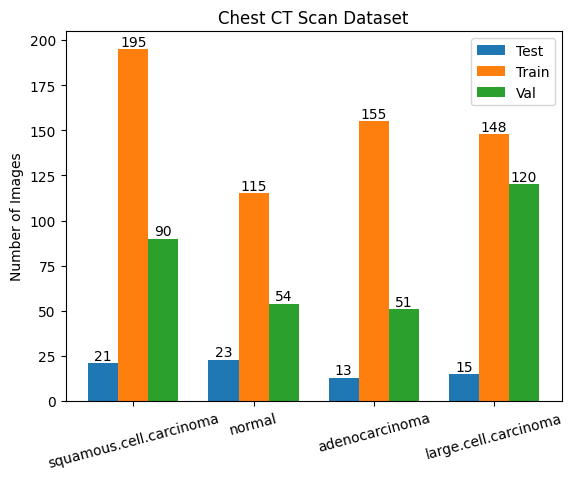

In [36]:
import matplotlib.pyplot as plt
labels = ["squamous.cell.carcinoma", "normal", "adenocarcinoma", "large.cell.carcinoma"]

test_list = list(test_set.values())
train_list = list(train_set.values())
val_list = list(val_set.values())

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
test_bar = ax.bar(x - width, test_list, width, label="Test")
train_bar = ax.bar(x, train_list, width, label="Train")
val_bar = ax.bar(x + width, val_list, width, label="Val")

ax.set_ylabel('Number of Images')
ax.set_title('Chest CT Scan Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(test_bar)
ax.bar_label(train_bar)
ax.bar_label(val_bar)
plt.show()

In [37]:
class_dict = {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib':"Adenocarcinoma",'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa':'large.cell.carcinoma',
              'normal':'normal','squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa':"squamous.cell.carcinoma"}
class_dict

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large.cell.carcinoma',
 'normal': 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous.cell.carcinoma'}

In [38]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE),
batch_size = batch_size,
color_mode = "grayscale")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE),
batch_size = batch_size,
color_mode = "grayscale")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
valid_dir,
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE),
batch_size = batch_size,
color_mode = "grayscale")

Found 72 files belonging to 4 classes.
Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [39]:
test_class_names = test_ds.class_names
test_class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

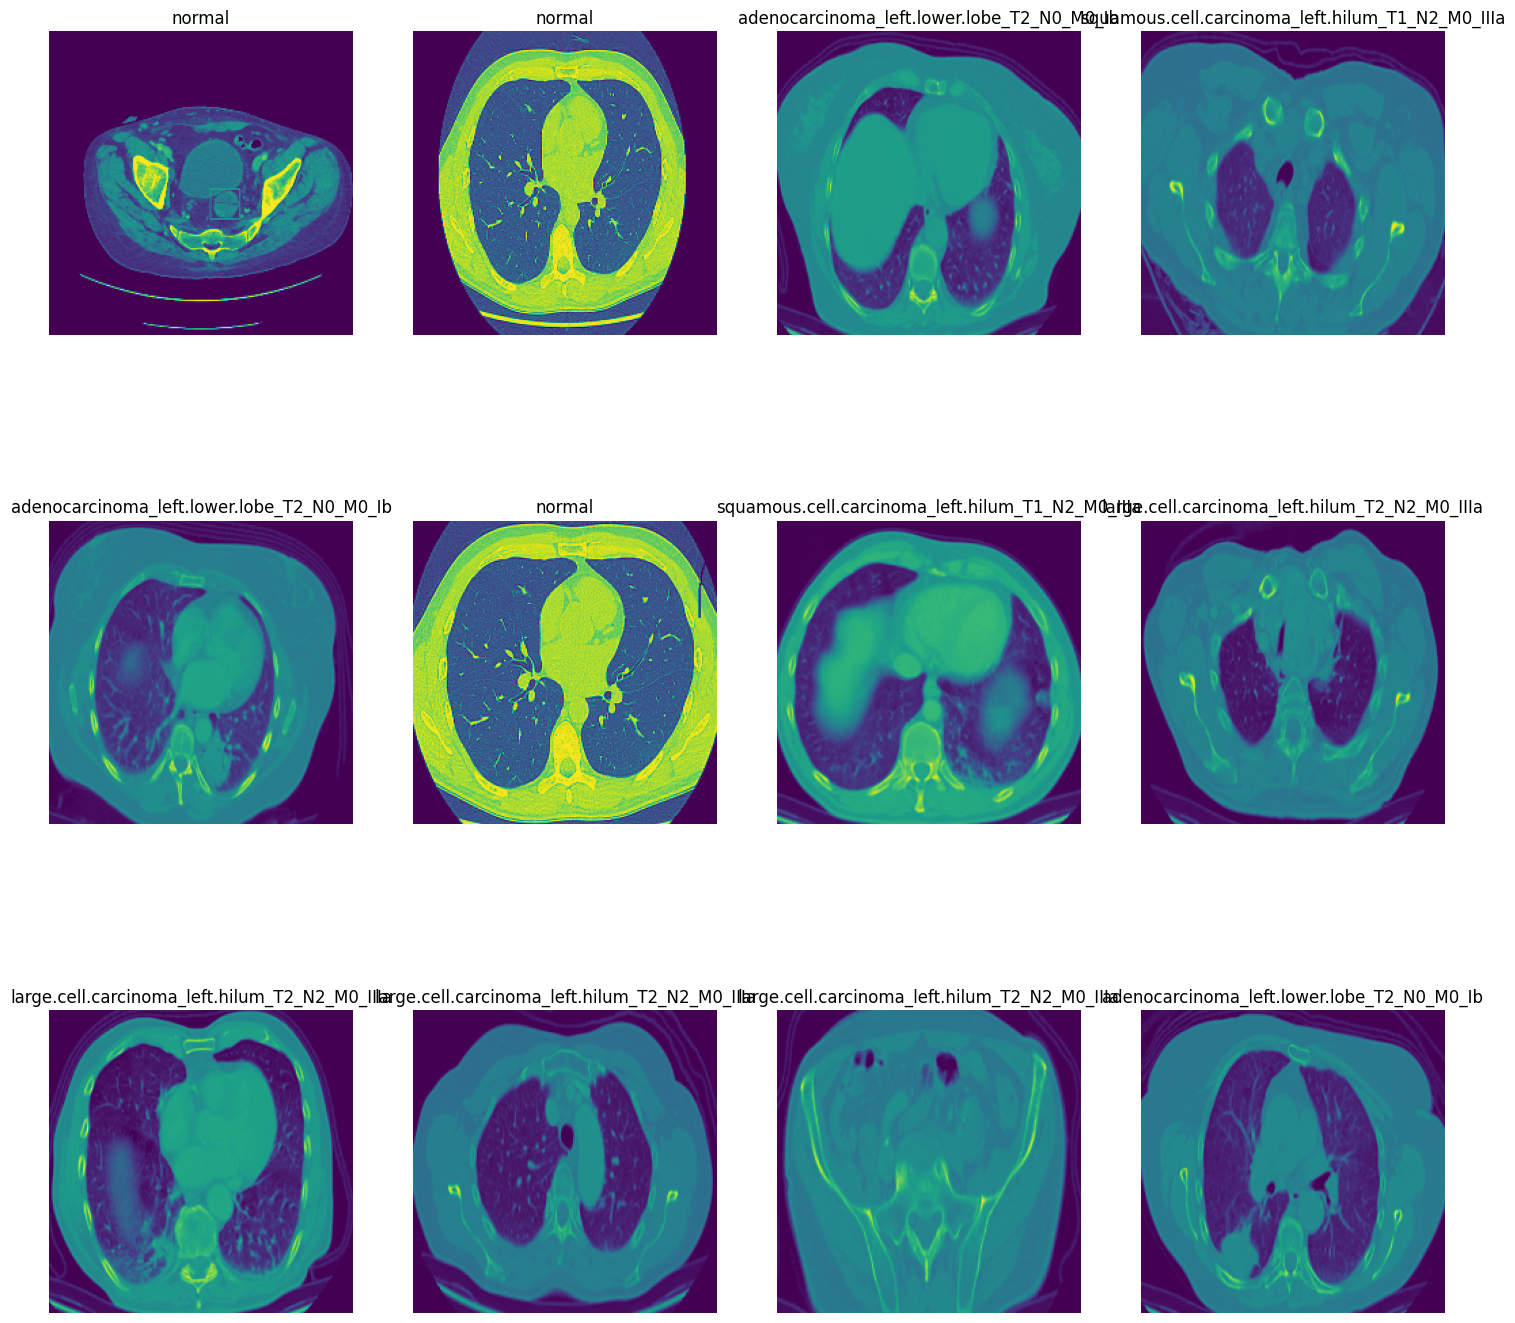

In [41]:
plt.figure(figsize=(18,18))
for image_batch, label_batch in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(test_class_names[label_batch[i]])
    plt.axis("off")

In [42]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/DSML/Data/train/adenoca...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,/content/drive/MyDrive/DSML/Data/train/adenoca...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,/content/drive/MyDrive/DSML/Data/train/adenoca...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,/content/drive/MyDrive/DSML/Data/train/adenoca...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,/content/drive/MyDrive/DSML/Data/train/adenoca...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
...,...,...
608,/content/drive/MyDrive/DSML/Data/train/normal/...,normal
609,/content/drive/MyDrive/DSML/Data/train/normal/...,normal
610,/content/drive/MyDrive/DSML/Data/train/normal/...,normal
611,/content/drive/MyDrive/DSML/Data/train/normal/...,normal


# **1. VGG16**

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


img_size = (224, 224)
channels = 3
def preprocess_input_vgg16(img):
      return tf.keras.applications.vgg16.preprocess_input(img)
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [92]:
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [93]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [95]:
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, early_stopping])

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.5220
Epoch 1: val_accuracy improved from -inf to 0.23810, saving model to best_model.h5
16/16 [==============================] - 40s 2s/step - loss: 1.6045 - accuracy: 0.5220 - val_loss: 8.7267 - val_accuracy: 0.2381
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.7863
Epoch 2: val_accuracy improved from 0.23810 to 0.48571, saving model to best_model.h5
16/16 [==============================] - 11s 711ms/step - loss: 0.9291 - accuracy: 0.7863 - val_loss: 3.2405 - val_accuracy: 0.4857
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.8206
Epoch 3: val_accuracy improved from 0.48571 to 0.54603, saving model to best_model.h5
16/16 [==============================] - 10s 631ms/step - loss: 0.7931 - accuracy: 0.8206 - val_loss: 2.7451 - val_accuracy: 0.5460
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss

In [96]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 14s 14s/step - loss: 0.8143 - accuracy: 0.8750
Train Loss:  0.26344791054725647
Train Accuracy:  1.0
--------------------
Validation Loss:  0.7652099132537842
Validation Accuracy:  0.7250000238418579
--------------------
Test Loss:  0.8143118619918823
Test Accuracy:  0.875


# **2. ResNet50**

In [76]:
from tensorflow.keras.applications import ResNet50
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [77]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(class_count, activation='softmax')])

In [78]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'best_model_resnet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, early_stopping])

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9967
Epoch 1: val_accuracy improved from -inf to 0.77460, saving model to best_model_resnet.h5
16/16 [==============================] - 11s 717ms/step - loss: 0.2822 - accuracy: 0.9967 - val_loss: 0.9367 - val_accuracy: 0.7746
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9984
Epoch 2: val_accuracy did not improve from 0.77460
16/16 [==============================] - 10s 656ms/step - loss: 0.2679 - accuracy: 0.9984 - val_loss: 0.9279 - val_accuracy: 0.7683
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9967
Epoch 3: val_accuracy improved from 0.77460 to 0.79365, saving model to best_model_resnet.h5
16/16 [==============================] - 10s 643ms/step - loss: 0.2669 - accuracy: 0.9967 - val_loss: 0.8945 - val_accuracy: 0.7937
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.2569 - accurac

In [83]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 5s 5s/step - loss: 0.6906 - accuracy: 0.8889
Train Loss:  0.22874422371387482
Train Accuracy:  1.0
--------------------
Validation Loss:  0.8342611193656921
Validation Accuracy:  0.8500000238418579
--------------------
Test Loss:  0.6906217932701111
Test Accuracy:  0.8888888955116272


# **3. InceptionV3**

In [84]:
from tensorflow.keras.applications import InceptionV3

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [85]:
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(class_count, activation='softmax')])

In [86]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
filepath = 'best_model_inceptionv3.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [88]:
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, early_stopping])

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 2.2818 - accuracy: 0.5432
Epoch 1: val_accuracy improved from -inf to 0.17143, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 17s 671ms/step - loss: 2.2818 - accuracy: 0.5432 - val_loss: 19.6927 - val_accuracy: 0.1714
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.5386 - accuracy: 0.6607
Epoch 2: val_accuracy improved from 0.17143 to 0.31746, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 10s 628ms/step - loss: 1.5386 - accuracy: 0.6607 - val_loss: 11.9967 - val_accuracy: 0.3175
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.4271 - accuracy: 0.7178
Epoch 3: val_accuracy did not improve from 0.31746
16/16 [==============================] - 9s 613ms/step - loss: 1.4271 - accuracy: 0.7178 - val_loss: 4.9921 - val_accuracy: 0.2476
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 1.166

In [89]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model_inceptionv3.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 1s/step - loss: 1.2078 - accuracy: 0.7083
Train Loss:  0.4817294180393219
Train Accuracy:  0.9750000238418579
--------------------
Validation Loss:  1.6334832906723022
Validation Accuracy:  0.625
--------------------
Test Loss:  1.2077960968017578
Test Accuracy:  0.7083333134651184


# **4. Ensemble Model**

In [97]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape=img_shape

model_inceptionv3 = load_model('best_model_inceptionv3.h5')
model = load_model('best_model.h5')
model_resnet = load_model('best_model_resnet.h5')

input_layer = Input(shape=(input_shape))


output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

average = Average()([output_inceptionv3, output_model, output_resnet])

In [98]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model = Model(inputs=input_layer, outputs=average)
ensemble_model.save('final_ensemble_model.h5')

In [99]:
model = load_model('final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-99-3cd860a06f01>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[1 1 1 3 1 0 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 3 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3]


In [100]:
import tensorflow as tf

model = tf.keras.models.load_model('final_ensemble_model.h5')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

1/1 [==============================] - 7s 7s/step - loss: 1.3271 - accuracy: 0.9028
Test Loss: 1.3270959854125977
Test Accuracy: 0.9027777910232544


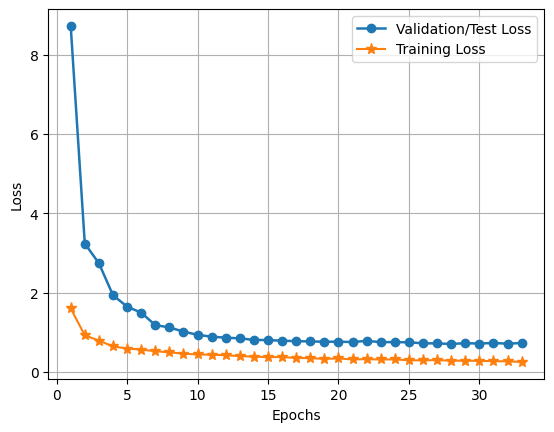

In [101]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

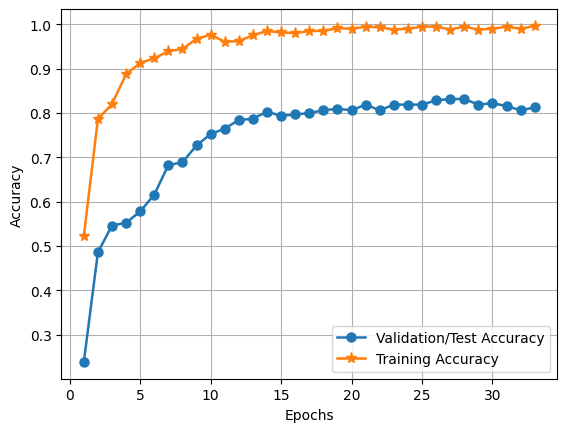

In [102]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [103]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[21  0  0  2]
 [ 2 17  0  2]
 [ 0  0 13  0]
 [ 1  0  0 14]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.88      0.91      0.89        23
   large-cell-carcinoma       1.00      0.81      0.89        21
                 normal       1.00      1.00      1.00        13
squamous-cell-carcinoma       0.78      0.93      0.85        15

               accuracy                           0.90        72
              macro avg       0.91      0.91      0.91        72
           weighted avg       0.91      0.90      0.90        72



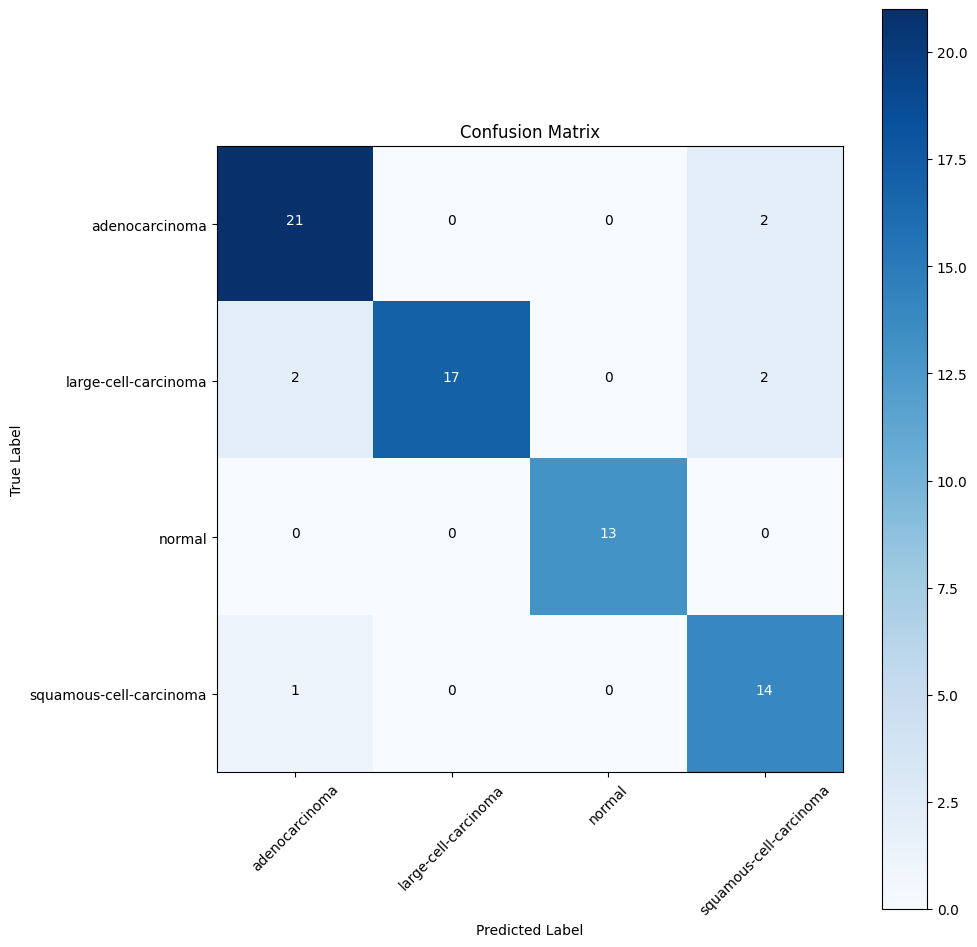

In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(test_gen.classes, y_pred, target_names= target_names))